In [1]:
#importing necessary python packages
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir('C:\\RESEARCH\\LUAD\\Regression') #setting the right directory

In [3]:
# Importing the dataset
dt = pd.read_excel('Gene Clinical.xlsx',index_col=0)


In [8]:
dt.shape

(517, 15151)

In [9]:
dt.head(2)

,UBE2Q2P2,SSX9,CXORF67,EFCAB8,SDR16C6P,EFCAB12,A1BG,A1CF,RBFOX1,GGACT,...,Tissue Source Site_MN,Tissue Source Site_MP,Tissue Source Site_NJ,Tissue Source Site_O1,Tissue Source Site_S2,Person Neoplasm Status_TUMOR FREE,Person Neoplasm Status_WITH TUMOR,Vial number_A,Vial number_B,Overall Survival (Months)
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,-0.4238,-0.1379,-0.1805,0.4529,-0.3317,-0.1012,-0.6977,-0.1476,-0.224,0.3832,...,0,0,0,0,0,1,0,1,0,0.00
TCGA-05-4249-01,-0.3291,-0.1379,-0.1805,-0.0869,-0.3317,-0.1661,-0.1483,-0.1371,-0.226,-0.5346,...,0,0,0,0,0,1,0,1,0,50.03


In [12]:
X = dt.iloc[:,0:15149].values
y = dt.iloc[:, -1].values

In [13]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

In [15]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()

regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [16]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [17]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))



19.46746987951807
687.4043783132531
26.21839770682513
Variance score: -0.26


R^2 = -0.2581


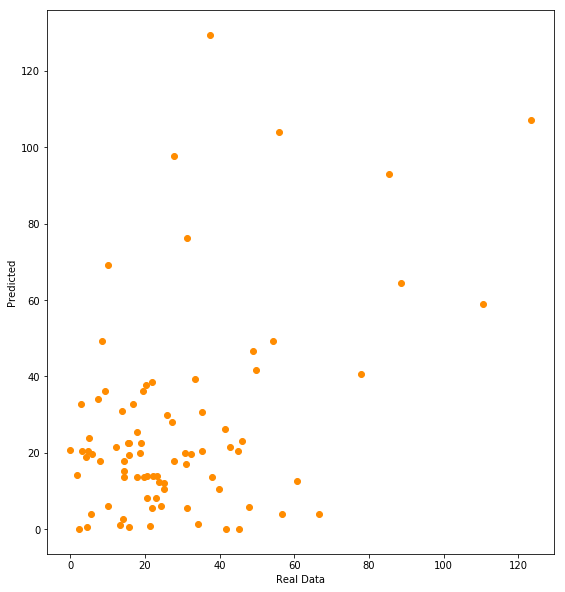

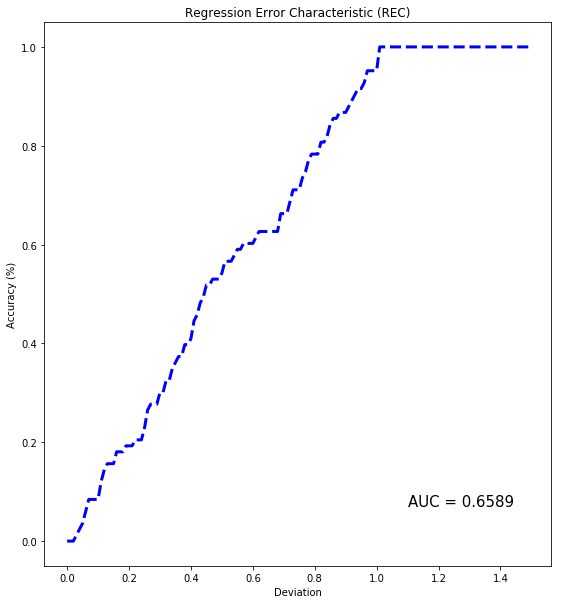

In [19]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [20]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {  'min_samples_split':[0.005,0.001,0.01,0.05,0.1,0.5,0.9]
                  
                 }  
regressor = DecisionTreeRegressor()
random=RandomizedSearchCV(estimator=regressor,param_distributions=param_grid,cv=3,n_jobs=-1)
random_result=random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_,random_result.best_params_))

C:\Users\Kanika Saini\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: -0.607614 using {'min_samples_split': 0.9}


In [21]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(min_samples_split = 0.9)

regressor.fit(X_train, y_train)
#Predicting the Validation set results
y_predval = regressor.predict(X_val)
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))


14.65287273156386
426.59342074104114
20.65413810211022
Variance score: 0.22


R^2 = 0.2192


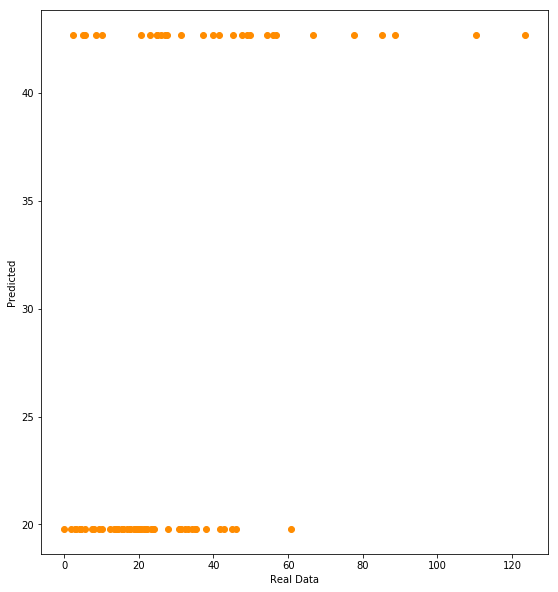

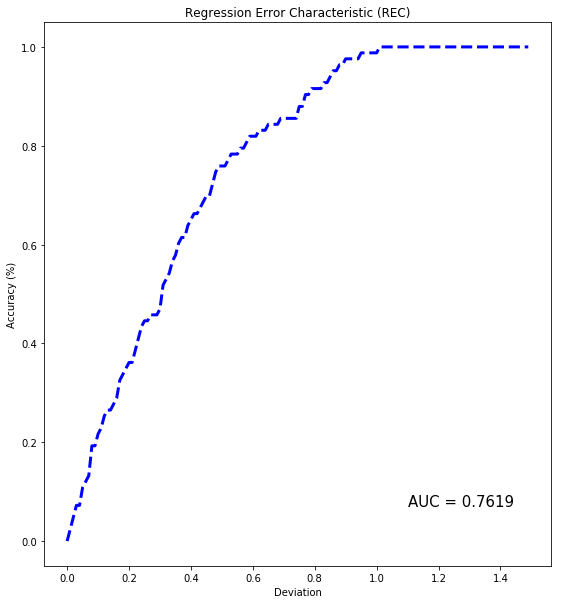

In [22]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [23]:
param_grid = {  'min_samples_split':[1.0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
                  
                 }  
regressor = DecisionTreeRegressor()
random=RandomizedSearchCV(estimator=regressor,param_distributions=param_grid,cv=3,n_jobs=-1)
random_result=random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_,random_result.best_params_))

Best: -0.469034 using {'min_samples_split': 1.0}


In [24]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(min_samples_split = 1.0)

regressor.fit(X_train, y_train)
#Predicting the Validation set results
y_predval = regressor.predict(X_val)
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))


16.998872155850208
546.4844034232843
23.377005869513837
Variance score: -0.00


R^2 = -0.0002


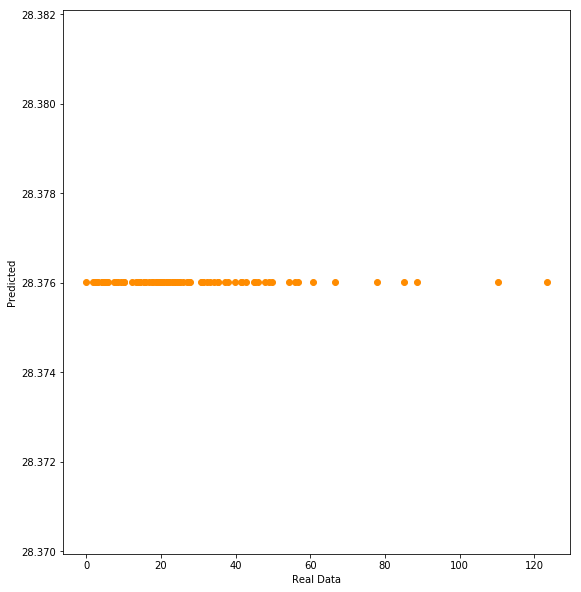

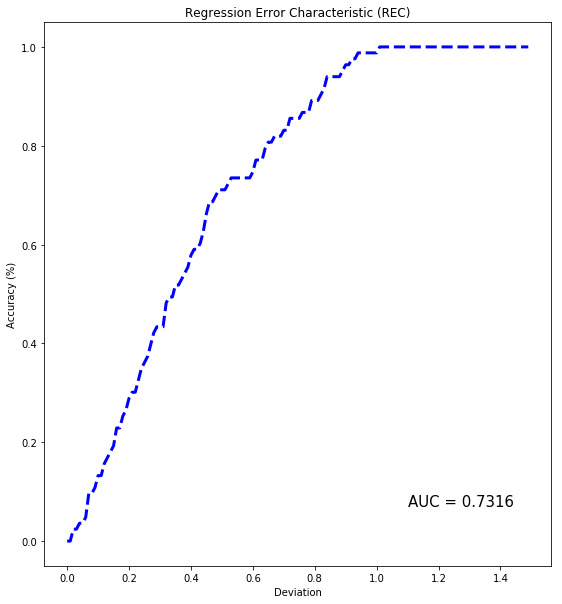

In [25]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [26]:
param_grid = {  'min_samples_split': [0.9],
              'max_depth': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,90,95,100]
              
                  
                 }  
regressor = DecisionTreeRegressor()
random=RandomizedSearchCV(estimator=regressor,param_distributions=param_grid,cv=3,n_jobs=-1)
random_result=random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_,random_result.best_params_))

Best: -0.469034 using {'min_samples_split': 0.9, 'max_depth': 1}


In [29]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(min_samples_split = 0.9,max_depth=10)

regressor.fit(X_train, y_train)
#Predicting the Validation set results
y_predval = regressor.predict(X_val)
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))


14.65287273156386
426.59342074104114
20.65413810211022
Variance score: 0.22


R^2 = 0.2192


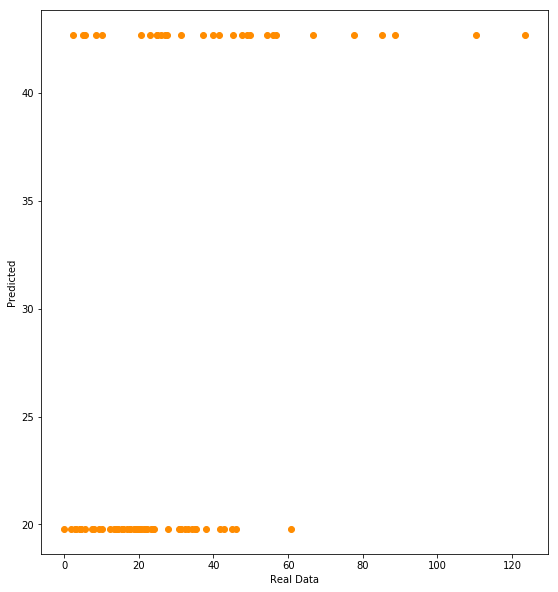

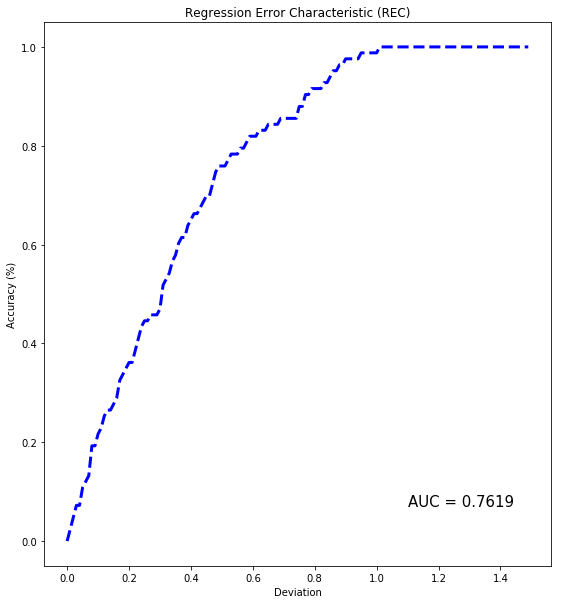

In [30]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [31]:

param_grid = {  'min_samples_split': [0.9],
              'max_depth': [10],
              'min_samples_leaf':[0.1,0.20,0.3,0.4,0.5]
              
                  
                 }  
regressor = DecisionTreeRegressor()
random=RandomizedSearchCV(estimator=regressor,param_distributions=param_grid,cv=3,n_jobs=-1)
random_result=random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_,random_result.best_params_)) 

C:\Users\Kanika Saini\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.119084 using {'min_samples_split': 0.9, 'min_samples_leaf': 0.3, 'max_depth': 10}


In [33]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(min_samples_split = 0.9,min_samples_leaf=0.3,max_depth=10)

regressor.fit(X_train, y_train)
#Predicting the Validation set results
y_predval = regressor.predict(X_val)
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))


14.739555776306688
426.93239961958415
20.6623425491783
Variance score: 0.22


R^2 = 0.2186


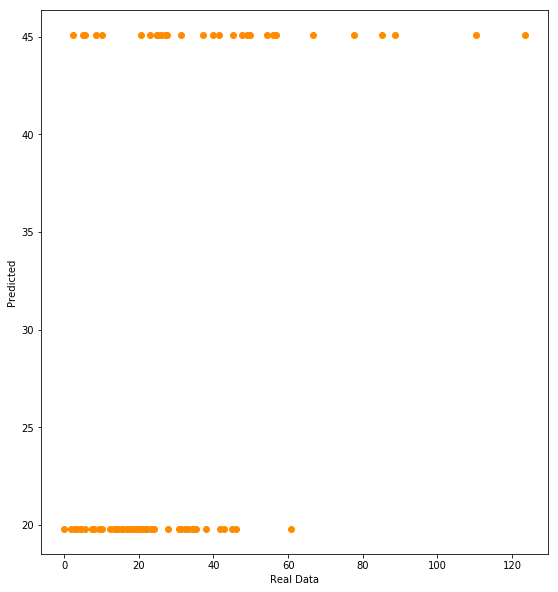

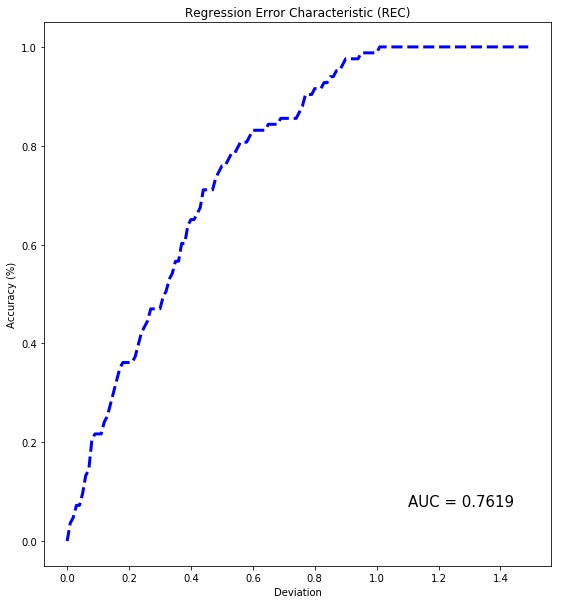

In [34]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [35]:

param_grid = {  'min_samples_split': [0.9],
              'max_depth': [10],
              'min_samples_leaf':[0.3],
            
                  'min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5]
                 }  
regressor = DecisionTreeRegressor()
random=RandomizedSearchCV(estimator=regressor,param_distributions=param_grid,cv=3,n_jobs=-1)
random_result=random.fit(X_train,y_train)
print("Best: %f using %s" % (random_result.best_score_,random_result.best_params_)) 

C:\Users\Kanika Saini\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.119084 using {'min_weight_fraction_leaf': 0.1, 'min_samples_split': 0.9, 'min_samples_leaf': 0.3, 'max_depth': 10}


In [36]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(min_samples_split = 0.9,min_samples_leaf=0.3,max_depth=10,min_weight_fraction_leaf=0.1)

regressor.fit(X_train, y_train)
#Predicting the Validation set results
y_predval = regressor.predict(X_val)
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))


14.739555776306688
426.93239961958426
20.662342549178305
Variance score: 0.22


R^2 = 0.2186


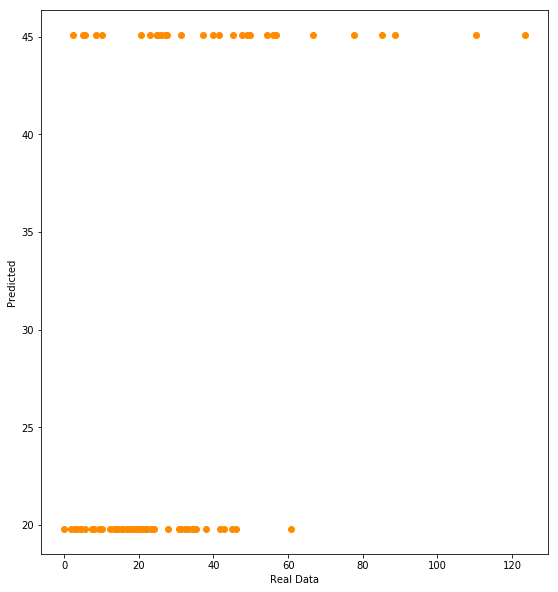

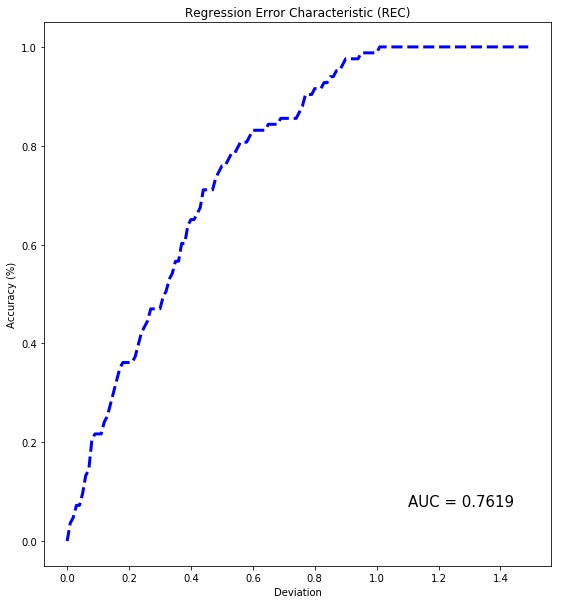

In [37]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()